# Archetype Analysis

In [1]:
from sklearn.datasets import load_iris

wine = load_iris()

X = wine.data
target = wine.target

In [2]:
from archetypes.sklearn import AA

model = AA(n_archetypes=3, max_iter=20, tol=1e-16, random_state=0, method="pgd")
model.fit(X)

model.archetypes_

array([[4.85460619, 3.42525024, 1.12426269, 0.16331521],
       [5.5826099 , 2.42508129, 4.91438005, 1.76067402],
       [7.74271329, 3.31367628, 6.5978311 , 2.20322973]])

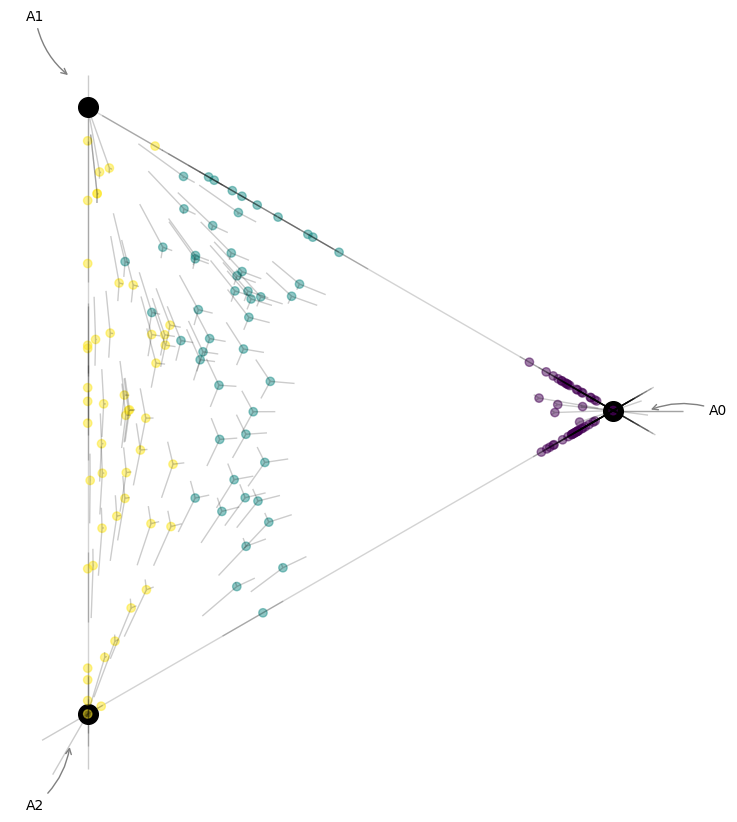

In [3]:
import matplotlib.pyplot as plt
from archetypes.visualization import simplex

plt.figure(figsize=(10, 10))
simplex(model.similarity_degree_, c=target, alpha=0.5, show_circle=False, show_direction=True)

plt.show()